In [68]:

import pandas as pd
import numpy as np
#import prospr as pr
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
import random
import csv
from collections import Counter
import itertools
import math
import ast


In [2]:
class Protein:
  def __init__(self, sequence , folds=[]):
    self.sequence = sequence
    self.hash_fold = folds
    self.loc_list = []
    self.score = (0,0)
    self.collisions = 0
    self.bonds = 0

    self.update_loc_list()
    self.update_score()

  def update_loc_list(self):

    self.loc_list = []
    moves = self.hash_fold

    vectors = [(0, -1),(1, 0),(0, 1),(-1, 0)]
    
    # Setup storage of the amino positions.
    cur_pos = [0,1]
    self.loc_list.append((0,0))
    self.loc_list.append((0,1))
    prev_move = (0,1)

    # Save the coordinates of the aminos in order.
    for direction in moves:
        if direction == 'L':
          move = vectors[(vectors.index(prev_move) - 1) % len(vectors)]
          prev_move = move
          cur_pos[0] += move[0]
          cur_pos[1] += move[1]
        if direction == 'R':
          move = vectors[(vectors.index(prev_move) + 1) % len(vectors)]
          prev_move = move
          cur_pos[0] += move[0]
          cur_pos[1] += move[1]
        if direction == 'S':
          move = prev_move
          cur_pos[0] += move[0]
          cur_pos[1] += move[1]
        self.loc_list.append(tuple(cur_pos))
    pass

  def random_fold(self):
    self.hash_fold = []
    for _ in range(len(self.sequence)-2) :
        direction = np.random.choice(["L","R","S"])
        self.hash_fold.append(direction)
    self.update_loc_list()
    pass

  def set_hash(self, index, direction, update = True):
    self.hash_fold[index] = direction

    if update:
      self.update_loc_list()
      self.update_score()
    pass

  def mutate(self):
    poss_move = ["L","R","S"]
    index = np.random.randint(0,len(self.hash_fold))
    poss_move.remove(self.hash_fold[index])
    self.hash_fold[index] = np.random.choice(poss_move)

    self.update_loc_list()
    self.update_score()
    pass

  def get_bonds(self):
    bonds = 0
    for i, loc in enumerate(self.loc_list):
      if self.sequence[i] == 'H':
         x,y = loc
         directions = [(1,0), (-1,0), (0,1), (0,-1)]
         neighbours = [(x + dx, y + dy) for dx, dy in directions]
         for neighbour in neighbours:
            if self.find_neighbours(neighbour, self.sequence[i+2:] ,self.loc_list[i+2:]):
               bonds += 1
    self.bonds = bonds
    return bonds

  def find_neighbours(self, loc, changed_seq, changed_loc):
    aminos = []
    for i, item in enumerate(changed_loc):
      if item == loc:
        if changed_seq[i] == 'H':
          aminos.append(i)
    if len(aminos) > 0:
       return True
    else:
       return False

  def get_collision(self):
    collision_count = 0
    visited_positions = set()

    for coordinate in self.loc_list:
        if coordinate in visited_positions:
            collision_count += 1
        else:
            visited_positions.add(coordinate)

    self.collisions = collision_count
    return collision_count

  def update_score(self):
    self.get_collision()
    self.get_bonds()
    self.score = (self.bonds, self.collisions)
    pass

  def __str__(self):
    return f"Protein: {len(self.sequence)}\nSequence: {self.sequence}\nFolds: {self.hash_fold}"



In [3]:
def hc_c(protein, max_iterations):
    data = []
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_collision()
    best_solution = current_protein.hash_fold
    data.append([0,best_fitness])

    for _ in range(1,max_iterations+1):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()

        if mutated_protein.collisions <= best_fitness:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            best_solution = current_protein.hash_fold
            best_fitness = current_protein.collisions
            data.append([_, best_fitness])

        #if _ % 100 == 0:
           #print("Interation: " + str(_) + " col: " + str(best_fitness))

    return current_protein, best_solution, best_fitness, data

In [4]:
def hc_c_ffa(protein, max_iterations):
    data = []
    fitness_dict = {}
    current_protein = Protein(protein.sequence, folds=list(protein.hash_fold))
    best_fitness = current_protein.get_collision()
    current_fitness = current_protein.get_collision()
    best_solution = current_protein.hash_fold
    data.append([0, current_fitness ,best_fitness])
    fitness_dict.setdefault(current_fitness, 1)

    for _ in range(1,max_iterations+1):
        mutated_protein = Protein(current_protein.sequence, folds=list(current_protein.hash_fold))
        mutated_protein.mutate()
        if mutated_protein.collisions in fitness_dict:
            fitness_dict[mutated_protein.collisions] += 1
        else:
            fitness_dict.setdefault(mutated_protein.collisions, 1)
        fitness_dict[current_fitness] += 1


        if fitness_dict[mutated_protein.collisions] <= fitness_dict[current_fitness]:
            current_protein = Protein(mutated_protein.sequence, folds=list(mutated_protein.hash_fold))
            current_fitness = current_protein.collisions

            if current_fitness <= best_fitness:
                best_solution = current_protein.hash_fold
                best_fitness = current_protein.collisions 
            
            data.append([_, current_fitness ,best_fitness])

        #if _ % 100 == 0:
        #   print("Interation: " + str(_))

    return current_protein, best_solution, best_fitness, data

In [5]:
def random_sequence(length, HP = 0.5):
    sequence = ""
    for i in range(length):
        if random.random() < HP:
            sequence += "P"
        else:
            sequence += "H"
    return sequence

In [91]:
numbers = range(5, 201, 5)

combined = []

for number in numbers:
    if number in [20, 60, 100, 120, 160, 200]:
        data = [] 
        for i in range(80):
            protein = Protein(random_sequence(number))
            protein.random_fold()
            data.append(protein)
        df = pd.DataFrame(data)
        combined.append(df)

# Create a single DataFrame from all generated DataFrames
Database4 = pd.concat(combined)

In [92]:
Database4.to_csv("Database4.csv")

In [93]:
# Open the CSV file in read mode
with open('Database4.csv', 'r') as csvfile:
    # Create a DictReader object
    reader = csv.DictReader(csvfile)

    # Convert each row to a dictionary
    data = []
    for row in reader:
        data.append(row)

    # Convert the list of dictionaries to a DataFrame
    Database4 = pd.DataFrame(data)

In [94]:
results = []
resultsFFA = []

for _, protein_data in Database4.iterrows():
    sequence = protein_data[1].split("\n")[1].split(":")[1].strip()   
    folds = eval(protein_data[1].split("\n")[2].split(":")[1].strip())
    protein = Protein(sequence, folds=folds)
    current_protein, best_solution, best_fitness, data = hc_c(protein, 100000)
    results.append([current_protein, best_solution, best_fitness, data])
    current_protein, best_solution, best_fitness, data = hc_c_ffa(protein, 100000)
    resultsFFA.append([current_protein, best_solution, best_fitness, data])

    print(str(len(sequence)) + " iter " + str(_))


20 iter 0
20 iter 1
20 iter 2
20 iter 3
20 iter 4
20 iter 5
20 iter 6
20 iter 7
20 iter 8
20 iter 9
20 iter 10
20 iter 11
20 iter 12
20 iter 13
20 iter 14
20 iter 15
20 iter 16
20 iter 17
20 iter 18
20 iter 19
20 iter 20
20 iter 21
20 iter 22
20 iter 23
20 iter 24
20 iter 25
20 iter 26
20 iter 27
20 iter 28
20 iter 29
20 iter 30
20 iter 31
20 iter 32
20 iter 33
20 iter 34
20 iter 35
20 iter 36
20 iter 37
20 iter 38
20 iter 39
20 iter 40
20 iter 41
20 iter 42
20 iter 43
20 iter 44
20 iter 45
20 iter 46
20 iter 47
20 iter 48
20 iter 49
20 iter 50
20 iter 51
20 iter 52
20 iter 53
20 iter 54
20 iter 55
20 iter 56
20 iter 57
20 iter 58
20 iter 59
20 iter 60
20 iter 61
20 iter 62
20 iter 63
20 iter 64
20 iter 65
20 iter 66
20 iter 67
20 iter 68
20 iter 69
20 iter 70
20 iter 71
20 iter 72
20 iter 73
20 iter 74
20 iter 75
20 iter 76
20 iter 77
20 iter 78
20 iter 79
60 iter 80
60 iter 81
60 iter 82
60 iter 83
60 iter 84
60 iter 85
60 iter 86
60 iter 87
60 iter 88
60 iter 89
60 iter 90
60 iter 9

In [95]:
df = pd.DataFrame(results)
df.to_json("Collisions4.json")
dfFFA = pd.DataFrame(resultsFFA)
dfFFA.to_json("Collisions_FFA4.json")

In [3]:
Coldf = pd.read_json("Collisions2.json")
ColdFFA = pd.read_json("Collisions_FFA2.json")

In [4]:
Coldf2 = pd.read_json("Collisions3.json")
ColdFFA2 = pd.read_json("Collisions_FFA3.json")

In [5]:
Coldf4 = pd.read_json("Collisions4.json")
ColdFFA4 = pd.read_json("Collisions_FFA4.json")

In [7]:
for i in range(0, len(ColdFFA2)):
    ColdFFA2['length'] = [20] * 10 + [60] * 10 + [100] * 10 + [120] * 10 + [160] * 10 + [200] * 10
for i in range(0, len(Coldf2)):
    Coldf2['length'] = [20] * 10 + [60] * 10 + [100] * 10 + [120] * 10 + [160] * 10 + [200] * 10
for i in range(0, len(ColdFFA)):
    ColdFFA['length'] = [20] * 10 + [60] * 10 + [100] * 10 + [120] * 10 + [160] * 10 + [200] * 10
for i in range(0, len(Coldf)):
    Coldf['length'] = [20] * 10 + [60] * 10 + [100] * 10 + [120] * 10 + [160] * 10 + [200] * 10
for i in range(0, len(ColdFFA4)):
    ColdFFA4['length'] = [20] * 80 + [60] * 80 + [100] * 80 + [120] * 80 + [160] * 80 + [200] * 80
for i in range(0, len(Coldf4)):
    Coldf4['length'] = [20] * 80 + [60] * 80 + [100] * 80 + [120] * 80 + [160] * 80 + [200] * 80

In [8]:
ColdFFA2 = ColdFFA2.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
Coldf2 = Coldf2.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
ColdFFA = ColdFFA.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
Coldf = Coldf.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
ColdFFA4 = ColdFFA4.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})
Coldf4 = Coldf4.rename(columns={0: "Final Protein", 1: "Fold", 2: "Fitness", 3: "Data"})

In [69]:
ColCdf = pd.concat([Coldf, Coldf2], ignore_index=True)
ColCdfFFa = pd.concat([ColdFFA, ColdFFA2], ignore_index=True)

In [11]:
Col20 = pd.concat([Coldf[Coldf['length'] == 20], Coldf2[Coldf2['length'] == 20], Coldf4[Coldf4['length'] == 20]], ignore_index=True)
Col60 = pd.concat([Coldf[Coldf['length'] == 60], Coldf2[Coldf2['length'] == 60], Coldf4[Coldf4['length'] == 60]], ignore_index=True)
Col100 = pd.concat([Coldf[Coldf['length'] == 100], Coldf2[Coldf2['length'] == 100], Coldf4[Coldf4['length'] == 100]], ignore_index=True)
Col120 = pd.concat([Coldf[Coldf['length'] == 120], Coldf2[Coldf2['length'] == 120], Coldf4[Coldf4['length'] == 120]], ignore_index=True)
Col160 = pd.concat([Coldf[Coldf['length'] == 160], Coldf2[Coldf2['length'] == 160], Coldf4[Coldf4['length'] == 160]], ignore_index=True)
Col200 = pd.concat([Coldf[Coldf['length'] == 200], Coldf2[Coldf2['length'] == 200], Coldf4[Coldf4['length'] == 200]], ignore_index=True)

In [31]:
Col20FFA = pd.concat([ColdFFA[ColdFFA['length'] == 20], ColdFFA2[ColdFFA2['length'] == 20], ColdFFA4[ColdFFA4['length'] == 20]], ignore_index=True)
Col60FFA = pd.concat([ColdFFA[ColdFFA['length'] == 60], ColdFFA2[ColdFFA2['length'] == 60], ColdFFA4[ColdFFA4['length'] == 60]], ignore_index=True)
Col100FFA = pd.concat([ColdFFA[ColdFFA['length'] == 100], ColdFFA2[ColdFFA2['length'] == 100], ColdFFA4[ColdFFA4['length'] == 100]], ignore_index=True)
Col120FFA = pd.concat([ColdFFA[ColdFFA['length'] == 120], ColdFFA2[ColdFFA2['length'] == 120], ColdFFA4[ColdFFA4['length'] == 120]], ignore_index=True)
Col160FFA = pd.concat([ColdFFA[ColdFFA['length'] == 160], ColdFFA2[ColdFFA2['length'] == 160], ColdFFA4[ColdFFA4['length'] == 160]], ignore_index=True)
Col200FFA = pd.concat([ColdFFA[ColdFFA['length'] == 200], ColdFFA2[ColdFFA2['length'] == 200], ColdFFA4[ColdFFA4['length'] == 200]], ignore_index=True)

In [25]:
dataFrames = []

for i in range(len(Col20)):
    # Access the data list for each entry
    data = Col20["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)

    df['length'] = 20

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col20_Data = pd.concat(dataFrames, ignore_index=True)

In [26]:
dataFrames = []

for i in range(len(Col60)):
    # Access the data list for each entry
    data = Col60["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)

    df['length'] = 60

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col60_Data = pd.concat(dataFrames, ignore_index=True)

In [27]:
dataFrames = []

for i in range(len(Col100)):
    # Access the data list for each entry
    data = Col100["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)

    df['length'] = 100

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col100_Data = pd.concat(dataFrames, ignore_index=True)

In [28]:
dataFrames = []

for i in range(len(Col120)):
    # Access the data list for each entry
    data = Col120["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)

    df['length'] = 120

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col120_Data = pd.concat(dataFrames, ignore_index=True)

In [29]:
dataFrames = []

for i in range(len(Col160)):
    # Access the data list for each entry
    data = Col160["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)

    df['length'] = 160

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col160_Data = pd.concat(dataFrames, ignore_index=True)

In [30]:
dataFrames = []

for i in range(len(Col200)):
    # Access the data list for each entry
    data = Col200["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)

    df['length'] = 200

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col200_Data = pd.concat(dataFrames, ignore_index=True)

In [54]:
dataFrames = []

for i in range(len(Col20FFA)):
    # Access the data list for each entry
    data = Col20FFA["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Current', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)
    df['Current'].ffill(inplace=True)

    df['length'] = 20

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col20FFA_Data = pd.concat(dataFrames, ignore_index=True)

In [55]:
dataFrames = []

for i in range(len(Col60FFA)):
    # Access the data list for each entry
    data = Col60FFA["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Current', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)
    df['Current'].ffill(inplace=True)

    df['length'] = 60

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col60FFA_Data = pd.concat(dataFrames, ignore_index=True)

In [56]:
dataFrames = []

for i in range(len(Col100FFA)):
    # Access the data list for each entry
    data = Col100FFA["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Current', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)
    df['Current'].ffill(inplace=True)

    df['length'] = 100

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col100FFA_Data = pd.concat(dataFrames, ignore_index=True)

In [57]:
dataFrames = []

for i in range(len(Col120FFA)):
    # Access the data list for each entry
    data = Col120FFA["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Current', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)
    df['Current'].ffill(inplace=True)

    df['length'] = 120

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col120FFA_Data = pd.concat(dataFrames, ignore_index=True)

In [58]:
dataFrames = []

for i in range(len(Col160FFA)):
    # Access the data list for each entry
    data = Col160FFA["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Current', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)
    df['Current'].ffill(inplace=True)

    df['length'] = 160

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col160FFA_Data = pd.concat(dataFrames, ignore_index=True)

In [59]:
dataFrames = []

for i in range(len(Col200FFA)):
    # Access the data list for each entry
    data = Col200FFA["Data"][i]
    
    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Iteration', 'Current', 'Fitness'])

    df = df.groupby('Iteration', as_index=False).mean()

    
    # Set 'Iteration' as the index
    df.set_index('Iteration', inplace=True)

    # Reindex the DataFrame to include all iterations
    df = df.reindex(np.arange(0, 100000))

    # Forward fill the missing fitness values
    df['Fitness'].ffill(inplace=True)
    df['Current'].ffill(inplace=True)

    df['length'] = 200

    # Reset the index
    df.reset_index(inplace=True)

    df['length'] = df['length'].astype(int)
        
    # Append the DataFrame to the list
    dataFrames.append(df)

# Concatenate all the DataFrames in the list into a new DataFrame
Col200FFA_Data = pd.concat(dataFrames, ignore_index=True)

In [60]:
AvgCol20_Data = Col20_Data.groupby(['Iteration', 'length'], as_index=False)['Fitness'].mean()
AvgCol60_Data = Col60_Data.groupby(['Iteration', 'length'], as_index=False)['Fitness'].mean()
AvgCol100_Data = Col100_Data.groupby(['Iteration', 'length'], as_index=False)['Fitness'].mean()
AvgCol120_Data = Col120_Data.groupby(['Iteration', 'length'], as_index=False)['Fitness'].mean()
AvgCol160_Data = Col160_Data.groupby(['Iteration', 'length'], as_index=False)['Fitness'].mean()
AvgCol200_Data = Col200_Data.groupby(['Iteration', 'length'], as_index=False)['Fitness'].mean()

AvgCol20FFA_Data = Col20FFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'Fitness':'mean', 'Current':'mean'})
AvgCol60FFA_Data = Col60FFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'Fitness':'mean', 'Current':'mean'})
AvgCol100FFA_Data = Col100FFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'Fitness':'mean', 'Current':'mean'})
AvgCol120FFA_Data = Col120FFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'Fitness':'mean', 'Current':'mean'})
AvgCol160FFA_Data = Col160FFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'Fitness':'mean', 'Current':'mean'})
AvgCol200FFA_Data = Col200FFA_Data.groupby(['Iteration', 'length'], as_index=False).agg({'Fitness':'mean', 'Current':'mean'})

In [61]:
AvgColFFA_Data = pd.concat([AvgCol20FFA_Data, AvgCol60FFA_Data, AvgCol100FFA_Data, AvgCol120FFA_Data, AvgCol160FFA_Data, AvgCol200FFA_Data], ignore_index=True)
AvgCol_Data = pd.concat([AvgCol20_Data, AvgCol60_Data, AvgCol100_Data, AvgCol120_Data, AvgCol160_Data, AvgCol200_Data], ignore_index=True)
Col_Data = pd.concat([Col20_Data, Col60_Data, Col100_Data, Col120_Data, Col160_Data, Col200_Data], ignore_index=True)
ColFFA_Data = pd.concat([Col20FFA_Data, Col60FFA_Data, Col100FFA_Data, Col120FFA_Data, Col160FFA_Data, Col200FFA_Data], ignore_index=True)

In [62]:
filtered_df = AvgColFFA_Data[AvgColFFA_Data['Fitness'] <= 0.5]

listFFA = filtered_df.groupby('length').agg({'Iteration': 'min'})
listFFA

,Iteration
length,
20,23
60,887
100,5359
120,8760
160,18568
200,36993


In [63]:
filtered_df = AvgCol_Data[AvgCol_Data['Fitness'] <= 0.5]

listC = filtered_df.groupby('length').agg({'Iteration': 'min'})
listC

,Iteration
length,
20,10
60,100
100,317
120,482
160,747
200,1152


In [64]:
merged_df = pd.merge(listFFA, listC, on='length', suffixes=('HC-FFA', 'HC'))
merged_df

,IterationHC-FFA,IterationHC
length,,
20,23,10
60,887,100
100,5359,317
120,8760,482
160,18568,747
200,36993,1152


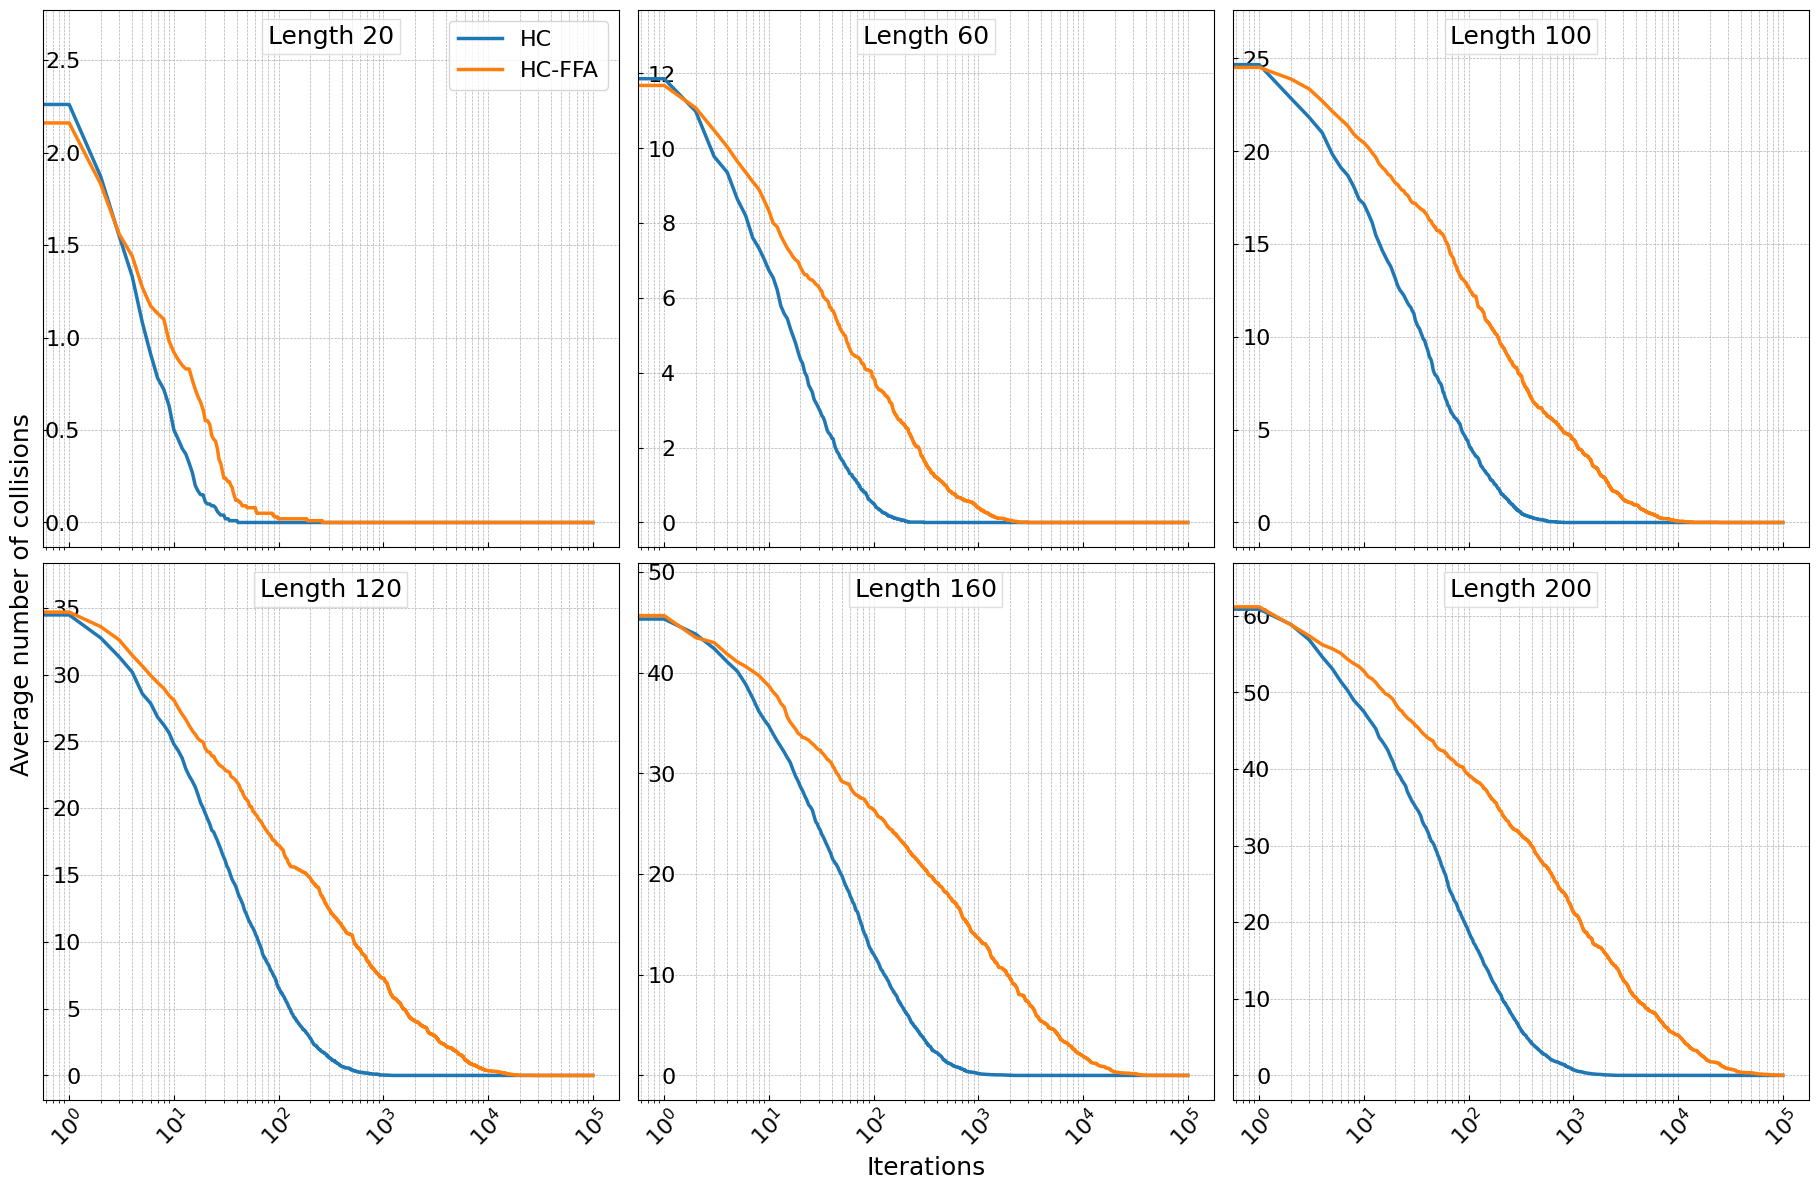

In [65]:
lengths = [20, 60, 100, 120, 160, 200]

# Increase figure size
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Add a figure title
#fig.suptitle('Collisions over iterations', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 3
    col = i % 3
    sns.lineplot(x='Iteration', y='Fitness', data=AvgCol_Data[AvgCol_Data['length'] == length], label='HC', linestyle="-", ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='Fitness', data=AvgColFFA_Data[AvgColFFA_Data['length'] == length], label='HC-FFA', linestyle="-", ax=axs[row, col], linewidth=2.5)

    axs[row, col].set_ylabel('', fontsize=18)
    axs[row, col].set_xscale('log')
    axs[row, col].tick_params(axis='x', rotation=45, direction='in', labelsize=16)
    axs[row, col].tick_params(axis='y', direction='in', labelsize=16, pad=-27) 
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)


    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    elif col == 1:
        axs[row, col].set_xlabel('Iterations', fontsize=18)
    else:
        axs[row, col].set_xlabel('')


    if col >= 1:
        axs[row, col].set_ylabel('')

    if i == 0:
        axs[row, col].legend(loc="upper right", prop={"size": 16})
        axs[row, col].text(0.5, 0.95, f'Length {length}', fontsize=18, ha='center', va='center', transform=axs[row, col].transAxes, bbox=dict(facecolor='white', alpha=0.75, edgecolor='lightgrey'))
    else:
        axs[row, col].legend([],[], frameon=False)
        axs[row, col].text(0.5, 0.95, f'Length {length}', fontsize=18, ha='center', va='center', transform=axs[row, col].transAxes, bbox=dict(facecolor='white', alpha=0.75, edgecolor='lightgrey'))

fig.text(-0.01, 0.5, 'Average number of collisions', va='center', rotation='vertical', fontsize=18)

plt.tight_layout()
plt.show()


In [69]:
def calculate_ci(data, confidence=0.95):
    """
    Calculate the mean and confidence interval of a dataset.

    Parameters:
    - data: 1D array or list
    - confidence: Confidence level (default is 0.95 for a 95% confidence interval)

    Returns:
    - mean: Mean of the data
    - lower_bound: Lower bound of the confidence interval
    - upper_bound: Upper bound of the confidence interval
    """
    mean = np.mean(data)
    n = len(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    margin = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    lower_bound = mean - margin
    upper_bound = mean + margin

    return mean, lower_bound, upper_bound

In [75]:
mean_HC, lower_HC, upper_HC = calculate_ci(Col_Data[Col_Data['length'] == 20]['Fitness'])


In [89]:
subset_data = Col_Data[(Col_Data['length'] == 20) & (Col_Data['Iteration'] == 0)]['Fitness']
subset_data


0          1.0
100000     2.0
200000     1.0
300000     7.0
400000     2.0
          ... 
9500000    2.0
9600000    4.0
9700000    6.0
9800000    0.0
9900000    3.0
Name: Fitness, Length: 100, dtype: float64

In [95]:
lengths = [20, 60, 100, 120, 160, 200]

ColCi_Dict = []
ColCiFFA_Dict = []

for iteration in range(100000):
    for length in lengths:
        subset_data = Col_Data[(Col_Data['length'] == length) & (Col_Data['Iteration'] == iteration)]['Fitness'].to_numpy()
        ci2 = 1.96 * np.std(subset_data) / np.sqrt(len(subset_data))
        ColCi_Dict.append({'Iteration': iteration, 'ci2': ci2, 'length': length})
        subsetFFA_data = ColFFA_Data[(ColFFA_Data['length'] == length) & (ColFFA_Data['Iteration'] == iteration)]['Fitness'].to_numpy()
        ci2FFA = 1.96 * np.std(subsetFFA_data) / np.sqrt(len(subsetFFA_data))
        ColCiFFA_Dict.append({'Iteration': iteration, 'ci2': ci2FFA, 'length': length})

ColCi_Data = pd.DataFrame(ColCi_Dict)
ColCiFFA_Data = pd.DataFrame(ColCiFFA_Dict)

KeyboardInterrupt: 

In [112]:
lengths = [20, 60, 100, 120, 160, 200]

ColCi_Dict = []

for length in lengths:
    HC_data = Col_Data[Col_Data['length'] == length]
                           
    for iteration in range(100000):
        if iteration % 10000 == 0:
            print(length, iteration)
        subset_data = HC_data[HC_data['Iteration'] == iteration]['Fitness'].to_numpy()
        if np.mean(subset_data) == 0:
            ci2 = 0
        else:
            ci2 = 1.96 * np.std(subset_data) / np.sqrt(len(subset_data))
        ColCi_Dict.append([iteration, ci2, length])

ColCi_Data = pd.DataFrame(ColCi_Dict)


20 0
20 10000
20 20000
20 30000
20 40000
20 50000
20 60000
20 70000
20 80000
20 90000
60 0
60 10000
60 20000
60 30000
60 40000
60 50000
60 60000
60 70000
60 80000
60 90000
100 0
100 10000
100 20000
100 30000
100 40000
100 50000
100 60000
100 70000
100 80000
100 90000
120 0
120 10000
120 20000
120 30000
120 40000
120 50000
120 60000
120 70000
120 80000
120 90000
160 0
160 10000
160 20000
160 30000
160 40000
160 50000
160 60000
160 70000
160 80000
160 90000
200 0
200 10000
200 20000
200 30000
200 40000
200 50000
200 60000
200 70000
200 80000
200 90000


In [113]:
lengths = [20, 60, 100, 120, 160, 200]

ColCiFFA_Dict = []

for length in lengths:
    FFA_data = ColFFA_Data[ColFFA_Data['length'] == length]
                           
    for iteration in range(100000):
        if iteration % 10000 == 0:
            print(length, iteration)
        subsetFFA_data = FFA_data[FFA_data['Iteration'] == iteration]['Fitness'].to_numpy()
        if np.mean(subsetFFA_data) == 0:
            ci2FFA = 0
        else:
            ci2FFA = 1.96 * np.std(subsetFFA_data) / np.sqrt(len(subsetFFA_data))
        ColCiFFA_Dict.append([iteration, ci2FFA, length])

ColCiFFA_Data = pd.DataFrame(ColCiFFA_Dict)

20 0
20 10000
20 20000
20 30000
20 40000
20 50000
20 60000
20 70000
20 80000
20 90000
60 0
60 10000
60 20000
60 30000
60 40000
60 50000
60 60000
60 70000
60 80000
60 90000
100 0
100 10000
100 20000
100 30000
100 40000
100 50000
100 60000
100 70000
100 80000
100 90000
120 0
120 10000
120 20000
120 30000
120 40000
120 50000
120 60000
120 70000
120 80000
120 90000
160 0
160 10000
160 20000
160 30000
160 40000
160 50000
160 60000
160 70000
160 80000
160 90000
200 0
200 10000
200 20000
200 30000
200 40000
200 50000
200 60000
200 70000
200 80000
200 90000


In [114]:
ColCi_Data.to_json("ColCi_Data.json")
ColCiFFA_Data.to_json("ColCiFFA_Data.json")

In [117]:
ColCiFFA_Data = ColCiFFA_Data.rename(columns={0: "Iteration", 1: "Fitness", 2: "length"})
ColCi_Data = ColCi_Data.rename(columns={0: "Iteration", 1: "Fitness", 2: "length"})

In [126]:
lower_HC = AvgCol_Data[AvgCol_Data['length'] == 20]['Fitness'] - ColCi_Data[ColCi_Data['length'] == 20]["Fitness"]

In [127]:
lower_HC

0        2.220066
1        1.870339
2        1.528650
3        1.227492
4        1.022517
           ...   
99995    0.000000
99996    0.000000
99997    0.000000
99998    0.000000
99999    0.000000
Name: Fitness, Length: 100000, dtype: float64

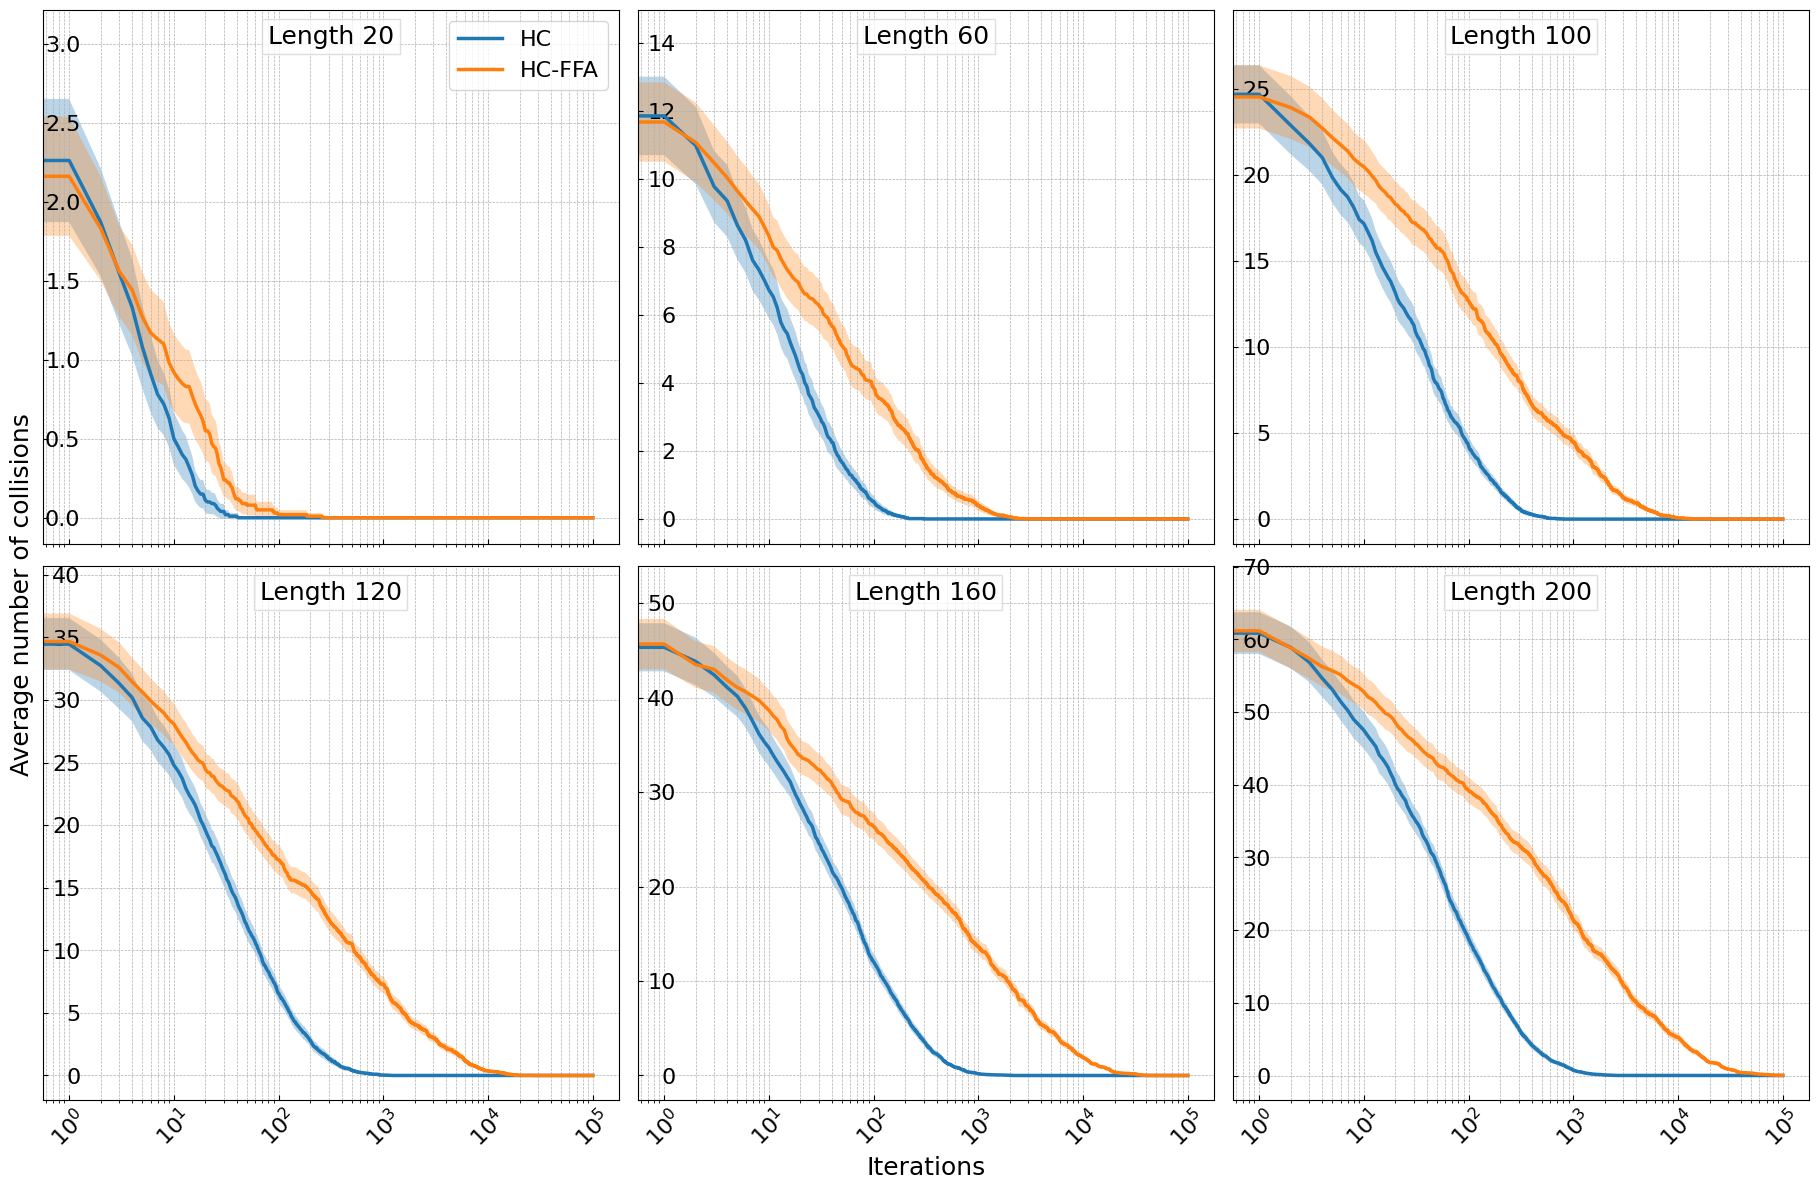

In [129]:
lengths = [20, 60, 100, 120, 160, 200]

# Increase figure size
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Add a figure title
#fig.suptitle('Collisions over iterations', fontsize=16)

for i, length in enumerate(lengths):
    row = i // 3
    col = i % 3
    #sns.lineplot(x='Iteration', y='Fitness', data=Col_Data[Col_Data['length'] == length], label='HC', linestyle="-", ax=axs[row, col], linewidth=2.5)
    #sns.lineplot(x='Iteration', y='Fitness', data=ColFFA_Data[ColFFA_Data['length'] == length], label='HC-FFA', linestyle="-", ax=axs[row, col], linewidth=2.5)

    # Calculate confidence intervals for HC data
    lower_HC = AvgCol_Data[AvgCol_Data['length'] == length]['Fitness'] - ColCi_Data[ColCi_Data['length'] == length]["Fitness"]
    upper_HC = AvgCol_Data[AvgCol_Data['length'] == length]['Fitness'] + ColCi_Data[ColCi_Data['length'] == length]["Fitness"]

    # Calculate confidence intervals for HC-FFA data
    lower_HCFFA = AvgColFFA_Data[AvgColFFA_Data['length'] == length]['Fitness'] - ColCiFFA_Data[ColCiFFA_Data['length'] == length]["Fitness"]
    upper_HCFFA = AvgColFFA_Data[AvgColFFA_Data['length'] == length]['Fitness'] + ColCiFFA_Data[ColCiFFA_Data['length'] == length]["Fitness"]

    # Plotting mean line with confidence interval
    sns.lineplot(x='Iteration', y='Fitness', data=AvgCol_Data[AvgCol_Data['length'] == length], label='HC', ax=axs[row, col], linewidth=2.5)
    sns.lineplot(x='Iteration', y='Fitness', data=AvgColFFA_Data[AvgColFFA_Data['length'] == length], label='HC-FFA', ax=axs[row, col], linewidth=2.5)

    axs[row, col].fill_between(x='Iteration', y1=lower_HC, y2=upper_HC, data=AvgCol_Data[AvgCol_Data['length'] == length], alpha=0.3)
    axs[row, col].fill_between(x='Iteration', y1=lower_HCFFA, y2=upper_HCFFA, data=AvgColFFA_Data[AvgColFFA_Data['length'] == length], alpha=0.3)

    axs[row, col].set_ylabel('', fontsize=18)
    axs[row, col].set_xscale('log')
    axs[row, col].tick_params(axis='x', rotation=45, direction='in', labelsize=16)
    axs[row, col].tick_params(axis='y', direction='in', labelsize=16, pad=-27) 
    axs[row, col].grid(True, which="both", linestyle="--", linewidth=0.5)


    # Remove x-axis label and values for the top graphs
    if row == 0:
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels([])
    elif col == 1:
        axs[row, col].set_xlabel('Iterations', fontsize=18)
    else:
        axs[row, col].set_xlabel('')


    if col >= 1:
        axs[row, col].set_ylabel('')

    if i == 0:
        axs[row, col].legend(loc="upper right", prop={"size": 16})
        axs[row, col].text(0.5, 0.95, f'Length {length}', fontsize=18, ha='center', va='center', transform=axs[row, col].transAxes, bbox=dict(facecolor='white', alpha=0.75, edgecolor='lightgrey'))
    else:
        axs[row, col].legend([],[], frameon=False)
        axs[row, col].text(0.5, 0.95, f'Length {length}', fontsize=18, ha='center', va='center', transform=axs[row, col].transAxes, bbox=dict(facecolor='white', alpha=0.75, edgecolor='lightgrey'))

fig.text(-0.01, 0.5, 'Average number of collisions', va='center', rotation='vertical', fontsize=18)

plt.tight_layout()
plt.show()


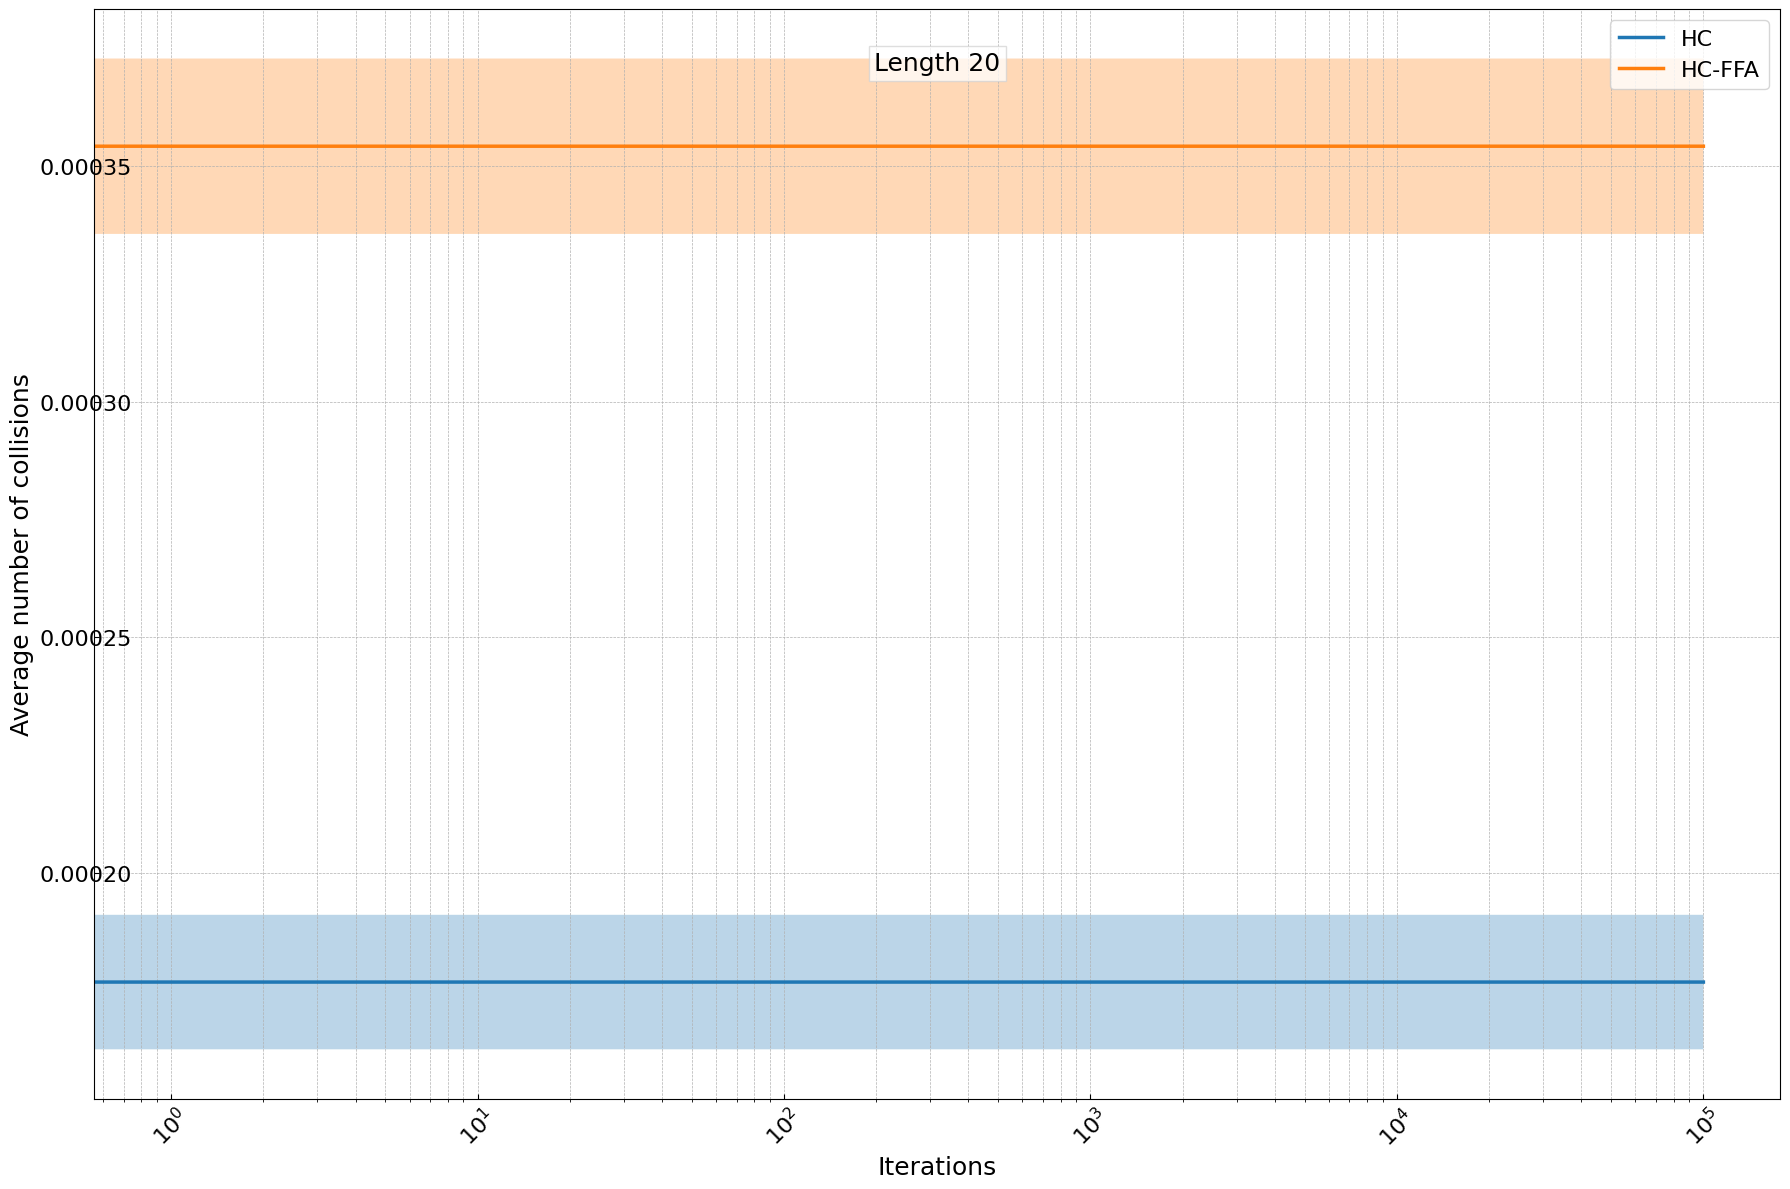

In [74]:
lengths = [20, 60, 100, 120, 160, 200]

# Increase figure size
fig, ax = plt.subplots(figsize=(18, 12))

# Add a figure title
# fig.suptitle('Collisions over iterations', fontsize=16)

for i, length in enumerate(lengths):
    if length == 20:
        # Handle length 20 separately
        # Calculate confidence intervals for HC data
        mean_HC, lower_HC, upper_HC = calculate_ci(Col_Data[Col_Data['length'] == length]['Fitness'])

        # Calculate confidence intervals for HC-FFA data
        mean_HCFFA, lower_HCFFA, upper_HCFFA = calculate_ci(ColFFA_Data[ColFFA_Data['length'] == length]['Fitness'])

        # Plotting mean line with confidence interval
        sns.lineplot(x='Iteration', y=mean_HC, data=Col_Data[Col_Data['length'] == length], label='HC', ax=ax, linewidth=2.5)
        sns.lineplot(x='Iteration', y=mean_HCFFA, data=ColFFA_Data[ColFFA_Data['length'] == length], label='HC-FFA', ax=ax, linewidth=2.5)

        ax.fill_between(x='Iteration', y1=lower_HC, y2=upper_HC, data=Col_Data[Col_Data['length'] == length], alpha=0.3)
        ax.fill_between(x='Iteration', y1=lower_HCFFA, y2=upper_HCFFA, data=ColFFA_Data[ColFFA_Data['length'] == length], alpha=0.3)

        ax.set_ylabel('', fontsize=18)
        ax.set_xscale('log')
        ax.tick_params(axis='x', rotation=45, direction='in', labelsize=16)
        ax.tick_params(axis='y', direction='in', labelsize=16, pad=-27) 
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

        ax.set_xlabel('Iterations', fontsize=18)
        ax.set_ylabel('Average number of collisions', fontsize=18)

        ax.legend(loc="upper right", prop={"size": 16})
        ax.text(0.5, 0.95, f'Length {length}', fontsize=18, ha='center', va='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.75, edgecolor='lightgrey'))

    else:
        # For other lengths, skip the plot
        continue

plt.tight_layout()
plt.show()